# EDA for Reddit- Wallstreebeets comments 2018-2019

references https://www.earthdatascience.org/courses/use-data-open-source-python/intro-to-apis/calculate-tweet-word-frequencies-in-python/

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import json
import vaex
import re
import itertools
import collections
import nltk
from nltk.corpus import stopwords
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer


### input data processing

The data was downloaded from the internet from  http://files.pushshift.io/reddit/comments/

The files are compressed in Zstandard format. A script was used to convert ehe files from Zst to JSON or CSV depending in the particular file. This was done outside of this jupyter notebook

In [2]:
# Import data from CSV with 
df_2018_2019 = vaex.from_csv('2018-2019.csv', convert=True, chunk_size=5_000_000, low_memory=False)


In [3]:
#check the number and type of variables
df_2018_2019.info()

In [4]:
#drop unnecesary columns

df_2018_2019 = df_2018_2019[['author', 'created_utc', 'body', 'score']]

In [5]:
# convert to PD to use pandas functionality to clean. 
df_2018_2019 = df_2018_2019.to_pandas_df()
df_2018_2019

,author,created_utc,body,score
0,[deleted],1.514765e+09,[removed],1.0
1,08371A,1.514765e+09,Bless you,6.0
2,Dick_Cuckingham,1.514765e+09,Long winded clickbait ad.,26.0
3,Shauncore,1.514765e+09,And that's part of the point. SPY isn't just a...,11.0
4,Shauncore,1.514765e+09,"Undergrad, grad school, the CFA exam, and Google.",6.0
...,...,...,...,...
5308862,omgoptions,1.577837e+09,Wow thank you for the positive feedback. Its r...,2.0
5308863,[deleted],1.577837e+09,And that’s enough internet for today,1.0
5308864,[deleted],1.577837e+09,33ish? Thx Obama.,30.0
5308865,phoq5,1.577837e+09,zaddi?,3.0


In [6]:
# update date format from epoch

df_2018_2019['created_utc'] = pd.to_datetime(df_2018_2019['created_utc'], unit='s', origin='unix')
df_2018_2019

,author,created_utc,body,score
0,[deleted],2018-01-01 00:00:08,[removed],1.0
1,08371A,2018-01-01 00:00:54,Bless you,6.0
2,Dick_Cuckingham,2018-01-01 00:02:28,Long winded clickbait ad.,26.0
3,Shauncore,2018-01-01 00:02:42,And that's part of the point. SPY isn't just a...,11.0
4,Shauncore,2018-01-01 00:03:25,"Undergrad, grad school, the CFA exam, and Google.",6.0
...,...,...,...,...
5308862,omgoptions,2019-12-31 23:58:51,Wow thank you for the positive feedback. Its r...,2.0
5308863,[deleted],2019-12-31 23:58:52,And that’s enough internet for today,1.0
5308864,[deleted],2019-12-31 23:58:56,33ish? Thx Obama.,30.0
5308865,phoq5,2019-12-31 23:59:12,zaddi?,3.0


In [7]:
# drop any rows for comments that were deleted
df_2018_2019 = df_2018_2019.drop(df_2018_2019[(df_2018_2019.body == '[deleted]') | (df_2018_2019.body == '[removed]') ].index)

In [8]:
df_2018_2019

,author,created_utc,body,score
1,08371A,2018-01-01 00:00:54,Bless you,6.0
2,Dick_Cuckingham,2018-01-01 00:02:28,Long winded clickbait ad.,26.0
3,Shauncore,2018-01-01 00:02:42,And that's part of the point. SPY isn't just a...,11.0
4,Shauncore,2018-01-01 00:03:25,"Undergrad, grad school, the CFA exam, and Google.",6.0
6,watchthegaps,2018-01-01 00:04:20,AAPL\nMTCH\nAMD\nDIS,1.0
...,...,...,...,...
5308862,omgoptions,2019-12-31 23:58:51,Wow thank you for the positive feedback. Its r...,2.0
5308863,[deleted],2019-12-31 23:58:52,And that’s enough internet for today,1.0
5308864,[deleted],2019-12-31 23:58:56,33ish? Thx Obama.,30.0
5308865,phoq5,2019-12-31 23:59:12,zaddi?,3.0


In [9]:
df_2018_2019.shape

(4864170, 4)

In [10]:
# number of null values
df_final = df_2018_2019.isnull().sum().sort_values(ascending=False)
percent = (df_2018_2019.isnull().sum()*100/df_2018_2019.isnull().count()).sort_values(ascending=False)
df_missing = pd.concat([df_final,percent],axis = 1, keys = ['Total', "Percent"])
df_missing

,Total,Percent
body,45,0.000925
score,12,0.000247
created_utc,6,0.000123
author,0,0.000000


In [11]:
# there are 45 rows with empty messages, we;ll drop them. a very small fraction.
# This code displays the null values
#df_2018_2019[df_2018_2019.isnull().any(axis=1)]

df_2018_2019 = df_2018_2019.dropna(subset = ['created_utc','body'])

df_2018_2019[df_2018_2019.isnull().any(axis=1)]

,author,created_utc,body,score
140295,pewdiepew2,2018-02-16 22:40:51,I'm sorry I didn't get that.. I don't speak idiot,NaN
140302,pewdiepew2,2018-02-16 22:42:51,You have all the maturity of wine bottled yest...,NaN
140308,pewdiepew2,2018-02-16 22:45:30,I thought of you all day today. I was at the zoo.,NaN
866642,Frostfright,2018-08-15 19:31:19,Tfw tcehy is your largest holding,NaN
1065000,Bradley_Haran,2018-09-15 02:32:54,&gt; Bezos could give all his shares to all th...,NaN


In [12]:
# save to csv!
df_2018_2019.to_csv('2018_2019_clean.csv')

In [76]:
# this columns we havent used, do not creat them unless we want to do some plots about the time or days people post the most etc
# create year, month, day columns for the report

#df_2018_2019['day_of_week'] = df_2018_2019['created_utc'].dt.day_name()
#df_2018_2019['day_index'] = df_2018_2019['created_utc'].dt.dayofweek
#df_2018_2019['day'] = df_2018_2019['created_utc'].dt.day
#df_2018_2019['month'] = df_2018_2019['created_utc'].dt.month
#df_2018_2019['year'] = df_2018_2019['created_utc'].dt.year

/var/folders/6g/gdb0jbcd2z1gp1wl7s548g7c0000gn/T/ipykernel_7062/3088468880.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2018_2019['day_of_week'] = df_2018_2019['created_utc'].dt.day_name()
/var/folders/6g/gdb0jbcd2z1gp1wl7s548g7c0000gn/T/ipykernel_7062/3088468880.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2018_2019['day_index'] = df_2018_2019['created_utc'].dt.dayofweek
/var/folders/6g/gdb0jbcd2z1gp1wl7s548g7c0000gn/T/ipykernel_7062/3088468880.py:5: SettingWithCopyWarning: 
A value is 

In [13]:
df_2018_2019

,author,created_utc,body,score
1,08371A,2018-01-01 00:00:54,Bless you,6.0
2,Dick_Cuckingham,2018-01-01 00:02:28,Long winded clickbait ad.,26.0
3,Shauncore,2018-01-01 00:02:42,And that's part of the point. SPY isn't just a...,11.0
4,Shauncore,2018-01-01 00:03:25,"Undergrad, grad school, the CFA exam, and Google.",6.0
6,watchthegaps,2018-01-01 00:04:20,AAPL\nMTCH\nAMD\nDIS,1.0
...,...,...,...,...
5308862,omgoptions,2019-12-31 23:58:51,Wow thank you for the positive feedback. Its r...,2.0
5308863,[deleted],2019-12-31 23:58:52,And that’s enough internet for today,1.0
5308864,[deleted],2019-12-31 23:58:56,33ish? Thx Obama.,30.0
5308865,phoq5,2019-12-31 23:59:12,zaddi?,3.0


In [50]:
#merge all the months in a single DF
#frames = [df_2018, df_2019_Jan_March, df_2019_April, df_2019_May_December]
#df_merged = pd.concat(frames)

In [59]:
# save to csv!
#df_merged.to_csv('test_export')

# volume of comments

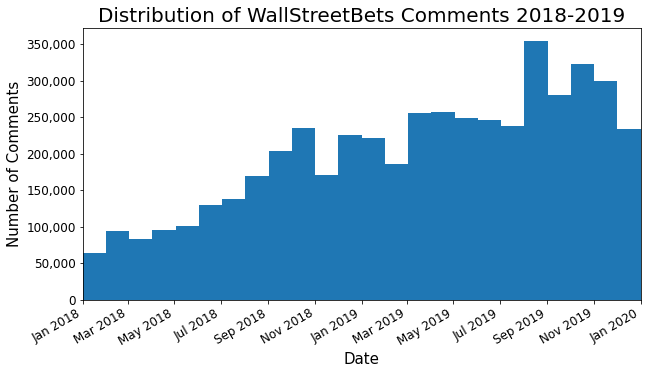

In [14]:
import matplotlib.ticker as mtick
import matplotlib.dates as mdates

fig, axs = plt.subplots(1,1, figsize=(10,5))
axs.hist(df_2018_2019['created_utc'],  bins=24, cumulative = False   )

axs.set( xlim = [datetime.datetime(2018, 1, 1),datetime.datetime(2020, 1, 1)],
       xlabel='Date', 
       ylabel='Number of Comments',
       title='Distribution of WallStreetBets Comments 2018-2019')

axs.get_yaxis().set_major_formatter(
mtick.FuncFormatter(lambda x, p: format(int(x), ',')))

axs.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
axs.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.setp(axs.get_xticklabels(), rotation=30, ha="right")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

axs.xaxis.label.set_size(15)
axs.yaxis.label.set_size(15)
axs.yaxis.label.set_size(15)
axs.title.set_size(20)

pass

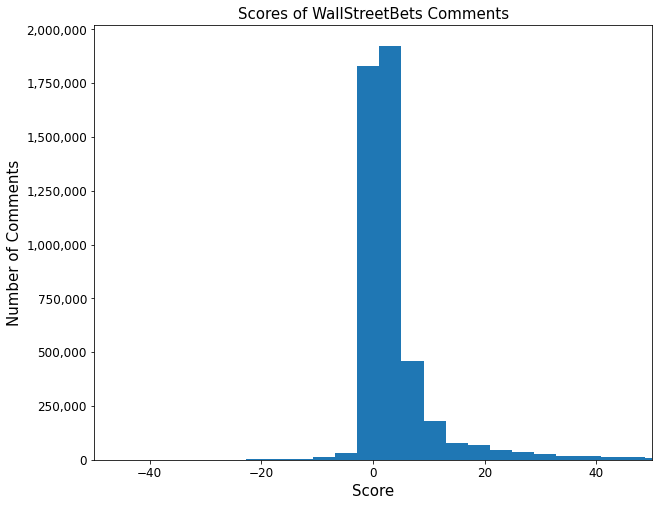

In [15]:
import matplotlib.ticker as mtick
import matplotlib.dates as mdates

fig, axs = plt.subplots(1,1, figsize=(10,8))
axs.hist(df_2018_2019['score'],  bins=3000, cumulative = False   )

axs.set( xlim = [-50,50], xlabel='Score', 
       ylabel='Number of Comments',
       title='Scores of WallStreetBets Comments')

axs.get_yaxis().set_major_formatter(
mtick.FuncFormatter(lambda x, p: format(int(x), ',')))

#plt.setp(axs.get_xticklabels(), rotation=30, ha="right")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

axs.xaxis.label.set_size(15)
axs.yaxis.label.set_size(15)
axs.yaxis.label.set_size(15)
axs.title.set_size(15)

pass

In [16]:
# remove all URLS from the strings

def remove_url(txt):
    """Replace URLs found in a text string with nothing 
    (i.e. it will remove the URL from the string).

    Parameters
    ----------
    txt : string
        A text string that you want to parse and remove urls.

    Returns
    -------
    The same txt string with url's removed.
    """

    return " ".join(re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", txt).split())

In [16]:
# save all the comments in a list
all_comments = df_2018_2019['body'].tolist()
all_comments[:5]

['Bless you',
 'Long winded clickbait ad.',
 "And that's part of the point. SPY isn't just a sector, and while it was affected, investors don't do all sector sell-offs as much as they do tech sell-offs and rotations.",
 'Undergrad, grad school, the CFA exam, and Google.',
 'AAPL\nMTCH\nAMD\nDIS']

In [128]:
#delete urls
all_comments_no_urls = [remove_url(comment) for comment in all_comments]
all_comments_no_urls[:5]

['Bless you',
 'Long winded clickbait ad',
 'And that s part of the point SPY isn t just a sector and while it was affected investors don t do all sector sell offs as much as they do tech sell offs and rotations',
 'Undergrad grad school the CFA exam and Google',
 'AAPL MTCH AMD DIS']

In [17]:
#delete urls from comments
df_2018_2019.loc[:,'body_no_urls']= df_2018_2019['body'].apply(remove_url)

/var/folders/6g/gdb0jbcd2z1gp1wl7s548g7c0000gn/T/ipykernel_17852/3993190744.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2018_2019.loc[:,'body_no_urls']= df_2018_2019['body'].apply(remove_url)


In [18]:
df_2018_2019

,author,created_utc,body,score,body_no_urls
1,08371A,2018-01-01 00:00:54,Bless you,6.0,Bless you
2,Dick_Cuckingham,2018-01-01 00:02:28,Long winded clickbait ad.,26.0,Long winded clickbait ad
3,Shauncore,2018-01-01 00:02:42,And that's part of the point. SPY isn't just a...,11.0,And that s part of the point SPY isn t just a ...
4,Shauncore,2018-01-01 00:03:25,"Undergrad, grad school, the CFA exam, and Google.",6.0,Undergrad grad school the CFA exam and Google
6,watchthegaps,2018-01-01 00:04:20,AAPL\nMTCH\nAMD\nDIS,1.0,AAPL MTCH AMD DIS
...,...,...,...,...,...
5308862,omgoptions,2019-12-31 23:58:51,Wow thank you for the positive feedback. Its r...,2.0,Wow thank you for the positive feedback Its ra...
5308863,[deleted],2019-12-31 23:58:52,And that’s enough internet for today,1.0,And that s enough internet for today
5308864,[deleted],2019-12-31 23:58:56,33ish? Thx Obama.,30.0,33ish Thx Obama
5308865,phoq5,2019-12-31 23:59:12,zaddi?,3.0,zaddi


In [85]:
# Create a list of lists containing lowercase words for each comment
words_in_comment = [comment.lower().split() for comment in all_comments_no_urls]
words_in_comment[:2]

[['bless', 'you'], ['long', 'winded', 'clickbait', 'ad']]

In [19]:
# Create a list of lists containing lowercase words for each comment
df_2018_2019.loc[:,'words_in_body']= df_2018_2019['body_no_urls'].str.lower()

/var/folders/6g/gdb0jbcd2z1gp1wl7s548g7c0000gn/T/ipykernel_17852/318336308.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2018_2019.loc[:,'words_in_body']= df_2018_2019['body_no_urls'].str.lower()


In [20]:
df_2018_2019

,author,created_utc,body,score,body_no_urls,words_in_body
1,08371A,2018-01-01 00:00:54,Bless you,6.0,Bless you,bless you
2,Dick_Cuckingham,2018-01-01 00:02:28,Long winded clickbait ad.,26.0,Long winded clickbait ad,long winded clickbait ad
3,Shauncore,2018-01-01 00:02:42,And that's part of the point. SPY isn't just a...,11.0,And that s part of the point SPY isn t just a ...,and that s part of the point spy isn t just a ...
4,Shauncore,2018-01-01 00:03:25,"Undergrad, grad school, the CFA exam, and Google.",6.0,Undergrad grad school the CFA exam and Google,undergrad grad school the cfa exam and google
6,watchthegaps,2018-01-01 00:04:20,AAPL\nMTCH\nAMD\nDIS,1.0,AAPL MTCH AMD DIS,aapl mtch amd dis
...,...,...,...,...,...,...
5308862,omgoptions,2019-12-31 23:58:51,Wow thank you for the positive feedback. Its r...,2.0,Wow thank you for the positive feedback Its ra...,wow thank you for the positive feedback its ra...
5308863,[deleted],2019-12-31 23:58:52,And that’s enough internet for today,1.0,And that s enough internet for today,and that s enough internet for today
5308864,[deleted],2019-12-31 23:58:56,33ish? Thx Obama.,30.0,33ish Thx Obama,33ish thx obama
5308865,phoq5,2019-12-31 23:59:12,zaddi?,3.0,zaddi,zaddi


In [90]:
# List of all words across comments
all_words_no_urls = list(itertools.chain(*words_in_comment))

# Create counter
counts_no_urls = collections.Counter(all_words_no_urls)

In [21]:
len(counts_no_urls)

NameError: name 'counts_no_urls' is not defined

In [23]:
clean_body_no_urls =df_2018_2019.words_in_body.str.split().explode().value_counts().to_frame()
clean_body_no_urls.reset_index(inplace = True)
clean_body_no_urls.rename(columns = {'index':'word', 'words_in_body':'count'}, inplace = True)
clean_body_no_urls.head(10)

,word,count
0,the,2655333
1,i,2178422
2,to,1897158
3,a,1776227
4,and,1460516
5,you,1368452
6,it,1343618
7,is,1175805
8,of,1069317
9,in,1036274


In [24]:
clean_comments_no_urls = pd.DataFrame(counts_no_urls.most_common(15),
                             columns=['words', 'count'])

clean_comments_no_urls.head(15)

NameError: name 'counts_no_urls' is not defined

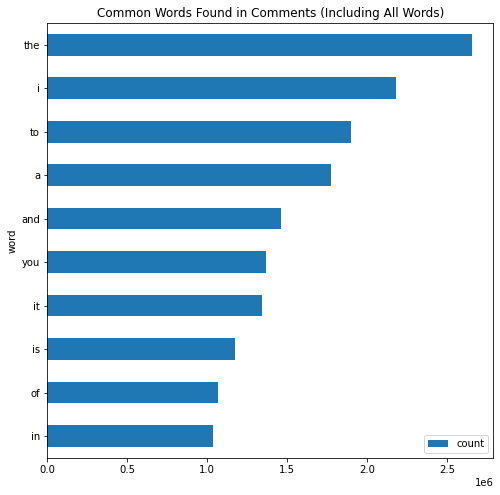

In [25]:
fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
clean_body_no_urls.sort_values(by='count', ascending=False).head(10).plot.barh(x='word',
                      y='count',
                      ax=ax,
                      )
ax.invert_yaxis()
ax.set_title("Common Words Found in Comments (Including All Words)")

plt.show()

In [26]:
# remove teh stopwoirds
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/javier/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [63]:
stop_words = set(stopwords.words('english'))

# View a few words from the set
list(stop_words)[0:10]

["you'd", 'an', 'over', "it's", 'in', 'o', "that'll", 'am', 'the', 'if']

In [101]:
# Remove stop words from each comment list of words
comments_nsw = [[word for word in comment_words if not word in stop_words]
              for comment_words in words_in_comment]

comments_nsw[0]

['bless']

In [102]:
#count the words withouth the stopwords

all_words_nsw = list(itertools.chain(*comments_nsw))

counts_nsw = collections.Counter(all_words_nsw)

counts_nsw.most_common(15)

[('like', 375906),
 ('im', 359080),
 ('calls', 293594),
 ('dont', 272073),
 ('get', 262768),
 ('puts', 236271),
 ('money', 226344),
 ('buy', 213954),
 ('going', 207016),
 ('market', 205341),
 ('think', 201749),
 ('would', 196717),
 ('go', 194866),
 ('good', 190774),
 ('one', 180499)]

In [105]:
counts_nsw.most_common(25)

[('like', 375906),
 ('im', 359080),
 ('calls', 293594),
 ('dont', 272073),
 ('get', 262768),
 ('puts', 236271),
 ('money', 226344),
 ('buy', 213954),
 ('going', 207016),
 ('market', 205341),
 ('think', 201749),
 ('would', 196717),
 ('go', 194866),
 ('good', 190774),
 ('one', 180499),
 ('time', 177198),
 ('shit', 167785),
 ('people', 156938),
 ('day', 153529),
 ('right', 149572),
 ('make', 148094),
 ('sell', 146489),
 ('thats', 146321),
 ('fuck', 144531),
 ('know', 143362)]

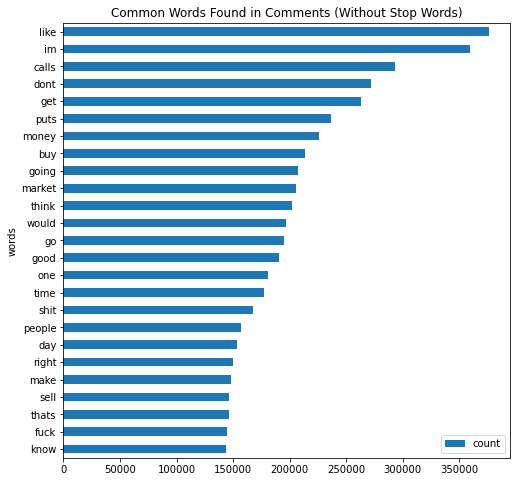

In [106]:
clean_comments_nsw = pd.DataFrame(counts_nsw.most_common(25),
                             columns=['words', 'count'])

fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
clean_comments_nsw.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax)

ax.set_title("Common Words Found in Comments (Without Stop Words)")

plt.show()

In [115]:
# remove other words from the count

collection_words = ['im', 'dont', 'thats', 'youre']

comments_nsw_nc = [[w for w in word if not w in collection_words]
                 for word in comments_nsw]

In [116]:
# Flatten list of words in clean tweets
all_words_nsw_nc = list(itertools.chain(*comments_nsw_nc))

# Create counter of words in clean tweets
counts_nsw_nc = collections.Counter(all_words_nsw_nc)

counts_nsw_nc.most_common(15)

[('like', 375906),
 ('calls', 293594),
 ('get', 262768),
 ('puts', 236271),
 ('money', 226344),
 ('buy', 213954),
 ('going', 207016),
 ('market', 205341),
 ('think', 201749),
 ('would', 196717),
 ('go', 194866),
 ('good', 190774),
 ('one', 180499),
 ('time', 177198),
 ('shit', 167785)]

In [117]:
clean_comments_ncw = pd.DataFrame(counts_nsw_nc.most_common(30),
                             columns=['words', 'count'])
clean_comments_ncw.head()

,words,count
0,like,375906
1,calls,293594
2,get,262768
3,puts,236271
4,money,226344


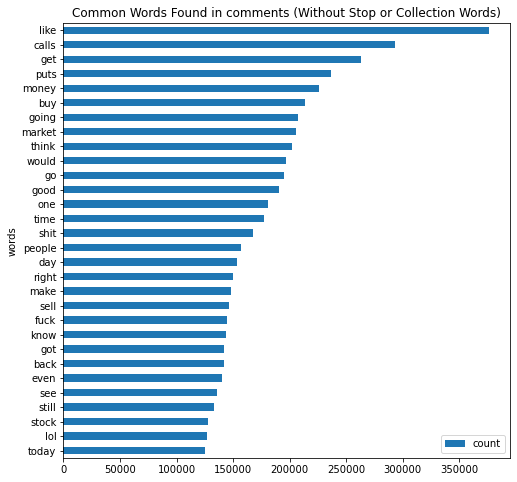

In [125]:
fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
clean_comments_ncw.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax)

ax.set_title("Common Words Found in comments (Without Stop or Collection Words)")

plt.show()

## Trying Textblob

In [27]:
# Create textblob objects of the comments
# this is very slow to use

sentiment_objects = [TextBlob(comment) for comment in all_comments_no_urls]

sentiment_objects[0].polarity, sentiment_objects[0]

NameError: name 'all_comments_no_urls' is not defined

In [124]:
sentiment_objects[20].polarity, sentiment_objects[20]

(0.25,
 TextBlob("AMD EBITDA 82Mdue to the first two quarters NVDA 307B INTC 2514B"))

In [28]:
#function to apply polarity
def detect_polarity(text):
    return TextBlob(text).sentiment.polarity

df_2018_2019['polarity'] = df_2018_2019['body_no_urls'].apply(detect_polarity)

df_2018_2019.head(10)

/var/folders/6g/gdb0jbcd2z1gp1wl7s548g7c0000gn/T/ipykernel_17852/85167624.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2018_2019['polarity'] = df_2018_2019['body_no_urls'].apply(detect_polarity)


,author,created_utc,body,score,body_no_urls,words_in_body,polarity
1,08371A,2018-01-01 00:00:54,Bless you,6.0,Bless you,bless you,0.000000
2,Dick_Cuckingham,2018-01-01 00:02:28,Long winded clickbait ad.,26.0,Long winded clickbait ad,long winded clickbait ad,-0.050000
3,Shauncore,2018-01-01 00:02:42,And that's part of the point. SPY isn't just a...,11.0,And that s part of the point SPY isn t just a ...,and that s part of the point spy isn t just a ...,0.200000
4,Shauncore,2018-01-01 00:03:25,"Undergrad, grad school, the CFA exam, and Google.",6.0,Undergrad grad school the CFA exam and Google,undergrad grad school the cfa exam and google,0.000000
6,watchthegaps,2018-01-01 00:04:20,AAPL\nMTCH\nAMD\nDIS,1.0,AAPL MTCH AMD DIS,aapl mtch amd dis,0.000000
7,Dick_Cuckingham,2018-01-01 00:04:36,That write up got bullish at the end. Said don...,8.0,That write up got bullish at the end Said don ...,that write up got bullish at the end said don ...,0.233333
8,zoltanyoursavior,2018-01-01 00:05:21,I got it from the pirate bay in a torrent. It'...,1.0,I got it from the pirate bay in a torrent It s...,i got it from the pirate bay in a torrent it s...,0.000000
9,Dick_Cuckingham,2018-01-01 00:05:46,"When MU does what that said it would do, they ...",1.0,When MU does what that said it would do they c...,when mu does what that said it would do they c...,0.000000
10,dvprz,2018-01-01 00:05:51,Thanks for buying them. I'll sell you some mor...,4.0,Thanks for buying them I ll sell you some more...,thanks for buying them i ll sell you some more...,0.166667
11,Dick_Cuckingham,2018-01-01 00:07:01,Less than a mile away.\n\nIs this the hot sing...,82.0,Less than a mile away Is this the hot singles ...,less than a mile away is this the hot singles ...,0.041667


In [33]:
df_2018_2019.head(20)

,author,created_utc,body,score,body_no_urls,words_in_body,polarity
1,08371A,2018-01-01 00:00:54,Bless you,6.0,Bless you,bless you,0.000000
2,Dick_Cuckingham,2018-01-01 00:02:28,Long winded clickbait ad.,26.0,Long winded clickbait ad,long winded clickbait ad,-0.050000
3,Shauncore,2018-01-01 00:02:42,And that's part of the point. SPY isn't just a...,11.0,And that s part of the point SPY isn t just a ...,and that s part of the point spy isn t just a ...,0.200000
4,Shauncore,2018-01-01 00:03:25,"Undergrad, grad school, the CFA exam, and Google.",6.0,Undergrad grad school the CFA exam and Google,undergrad grad school the cfa exam and google,0.000000
6,watchthegaps,2018-01-01 00:04:20,AAPL\nMTCH\nAMD\nDIS,1.0,AAPL MTCH AMD DIS,aapl mtch amd dis,0.000000
7,Dick_Cuckingham,2018-01-01 00:04:36,That write up got bullish at the end. Said don...,8.0,That write up got bullish at the end Said don ...,that write up got bullish at the end said don ...,0.233333
8,zoltanyoursavior,2018-01-01 00:05:21,I got it from the pirate bay in a torrent. It'...,1.0,I got it from the pirate bay in a torrent It s...,i got it from the pirate bay in a torrent it s...,0.000000
9,Dick_Cuckingham,2018-01-01 00:05:46,"When MU does what that said it would do, they ...",1.0,When MU does what that said it would do they c...,when mu does what that said it would do they c...,0.000000
10,dvprz,2018-01-01 00:05:51,Thanks for buying them. I'll sell you some mor...,4.0,Thanks for buying them I ll sell you some more...,thanks for buying them i ll sell you some more...,0.166667
11,Dick_Cuckingham,2018-01-01 00:07:01,Less than a mile away.\n\nIs this the hot sing...,82.0,Less than a mile away Is this the hot singles ...,less than a mile away is this the hot singles ...,0.041667


In [34]:
from pandas import option_context

with option_context('display.max_colwidth', 400):
    display(df_2018_2019.loc[df_2018_2019['polarity']<-0.5])

,author,created_utc,body,score,body_no_urls,words_in_body,polarity
31,onewonyuan,2018-01-01 00:39:31,"They lose a lot of money and everything they do is a disappointment, but it somehow manages to go up sometimes.",12.0,They lose a lot of money and everything they do is a disappointment but it somehow manages to go up sometimes,they lose a lot of money and everything they do is a disappointment but it somehow manages to go up sometimes,-0.600
110,alreadyinuse5000,2018-01-01 01:50:17,I'm retarded.,5.0,I m retarded,i m retarded,-0.800
116,NukeMagnet,2018-01-01 01:57:35,MU is going to be the worst investment of 2018. Calling it now.\n\nI'm a buy at $20,-7.0,MU is going to be the worst investment of 2018 Calling it now I m a buy at 20,mu is going to be the worst investment of 2018 calling it now i m a buy at 20,-1.000
124,sk8er4514,2018-01-01 02:13:56,I didn't realize that RAM prices have doubled in the past year or so. /r/pcmasterrace had some meme crap about that they hope RAM prices drop.,2.0,I didn t realize that RAM prices have doubled in the past year or so r pcmasterrace had some meme crap about that they hope RAM prices drop,i didn t realize that ram prices have doubled in the past year or so r pcmasterrace had some meme crap about that they hope ram prices drop,-0.525
206,Macabilly,2018-01-01 03:20:25,This is the worst post I've ever seen,10.0,This is the worst post I ve ever seen,this is the worst post i ve ever seen,-1.000
...,...,...,...,...,...,...,...
5308627,GaniB,2019-12-31 23:19:39,Tell her you're retarded,431.0,Tell her you re retarded,tell her you re retarded,-0.800
5308674,TheGuyAboveMeEatsPoo,2019-12-31 23:29:19,"It’s dangerous for Xi to leave the homeland. \n\nTrump goes where he pleases. \n\nIf you could help America and all it cost was a trip to China, would you refuse on the basis of pride?",-8.0,It s dangerous for Xi to leave the homeland Trump goes where he pleases If you could help America and all it cost was a trip to China would you refuse on the basis of pride,it s dangerous for xi to leave the homeland trump goes where he pleases if you could help america and all it cost was a trip to china would you refuse on the basis of pride,-0.600
5308771,fried-rice101,2019-12-31 23:46:50,You are just guessing here. Did you know that 95% of options expire worthless?,-13.0,You are just guessing here Did you know that 95 of options expire worthless,you are just guessing here did you know that 95 of options expire worthless,-0.800
5308825,redlotus70,2019-12-31 23:53:42,working at a job where you check out for 8 hours a day sounds absolutely horrible.,1.0,working at a job where you check out for 8 hours a day sounds absolutely horrible,working at a job where you check out for 8 hours a day sounds absolutely horrible,-1.000


In [ ]:
# how to make an average daily score of the sentiment in the forum??



In [35]:
from pandas import option_context

with option_context('display.max_colwidth', 400):
    display(df_2018_2019.loc[df_2018_2019['polarity']>0.8])

,author,created_utc,body,score,body_no_urls,words_in_body,polarity
223,MandemsMidkey,2018-01-01 03:35:22,"but there are also people who walk this earth that believe that they are perfect and are immune to making mistakes = these types won't fear making mistakes because they believe they can't.\n\nwhich, imo I think is a dumbass ideology",1.0,but there are also people who walk this earth that believe that they are perfect and are immune to making mistakes these types won t fear making mistakes because they believe they can t which imo I think is a dumbass ideology,but there are also people who walk this earth that believe that they are perfect and are immune to making mistakes these types won t fear making mistakes because they believe they can t which imo i think is a dumbass ideology,1.00
268,Sciencetist,2018-01-01 04:48:19,"And this, children, is why you set stop losses.\n\n*Stock drops 20% after rising 200%*\n\n'Hmm, this seems like a perfect time to buy'\n\nJust what.",-1.0,And this children is why you set stop losses Stock drops 20 after rising 200 Hmm this seems like a perfect time to buy Just what,and this children is why you set stop losses stock drops 20 after rising 200 hmm this seems like a perfect time to buy just what,1.00
382,OutofPlaceOneLiner,2018-01-01 08:19:16,"If this is your best writing and thinking performance, you probably shouldn't be investing.",3.0,If this is your best writing and thinking performance you probably shouldn t be investing,if this is your best writing and thinking performance you probably shouldn t be investing,1.00
863,Ya_boi_vlad,2018-01-01 20:26:02,Best car out there,161.0,Best car out there,best car out there,1.00
1351,superterrorizer,2018-01-02 03:20:00,Good for you !! We are all really impressed,21.0,Good for you We are all really impressed,good for you we are all really impressed,0.85
...,...,...,...,...,...,...,...
5308514,flat_line_,2019-12-31 22:54:01,"Get in mate, lock that fucker in. Excellent job",1.0,Get in mate lock that fucker in Excellent job,get in mate lock that fucker in excellent job,1.00
5308595,hellothere222,2019-12-31 23:11:50,That’s awesome. Guess he’s just taking a bit of risk off the table then.,1.0,That s awesome Guess he s just taking a bit of risk off the table then,that s awesome guess he s just taking a bit of risk off the table then,1.00
5308646,YeOldeFirstTimer,2019-12-31 23:22:43,MDF is beautiful to work with not even gonna lie😌🤤,2.0,MDF is beautiful to work with not even gonna lie,mdf is beautiful to work with not even gonna lie,0.85
5308723,ReverseMtg_BuyCalls,2019-12-31 23:38:48,This is awesome. Best of luck to you going forward,1.0,This is awesome Best of luck to you going forward,this is awesome best of luck to you going forward,1.00


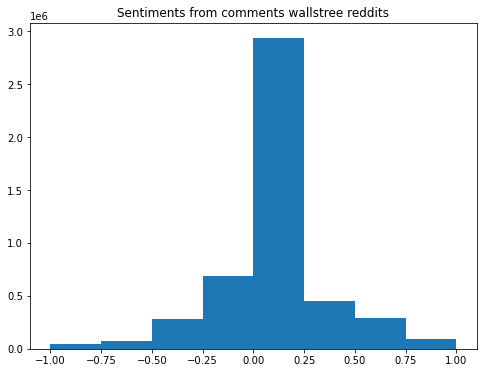

In [36]:
# plot histogram of polarity

fig, ax = plt.subplots(figsize=(8, 6))

# Plot histogram with break at zero
ax.hist(df_2018_2019['polarity'], bins=[-1, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1])

plt.title("Sentiments from comments wallstree reddits")
plt.show()

In [37]:
# make a daily line polot of commnets
test = pd.DataFrame(df_2018_2019.dtypes)
test.rename(columns = {0:'Data Type'})

# get 

,Data Type
author,object
created_utc,datetime64[ns]
body,object
score,float64
body_no_urls,object
words_in_body,object
polarity,float64


In [38]:
#Get the monthly count of posts

volume_posts = df_2018_2019.groupby(pd.Grouper(key='created_utc',freq='D'))['body'].count().to_frame(name = 'count').reset_index()

volume_posts.set_index('created_utc', inplace=True)

volume_posts

,count
created_utc,
2018-01-01,970
2018-01-02,1666
2018-01-03,2205
2018-01-04,2388
2018-01-05,2034
...,...
2019-12-27,8371
2019-12-28,4309
2019-12-29,2020


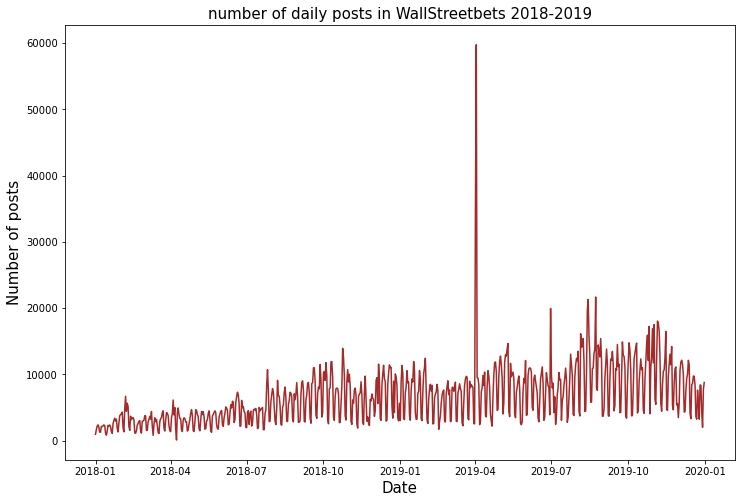

In [40]:
fig, axs = plt.subplots(1,1, figsize=(12,8))

axs.plot( volume_posts['count'], label = "Bernie Sanders", color = 'brown')
axs.set( 
       xlabel='Date', 
       ylabel='Number of posts',
       title='number of daily posts in WallStreetbets 2018-2019')
axs.xaxis.label.set_size(15)
axs.yaxis.label.set_size(15)
axs.yaxis.label.set_size(15)
axs.title.set_size(15)

In [41]:
#Get the average of polarity daily  of posts

daily_polarity_posts = df_2018_2019.groupby(pd.Grouper(key='created_utc',freq='D'))['polarity'].mean().to_frame(name = 'mean_polarity').reset_index()

daily_polarity_posts.set_index('created_utc', inplace=True)

daily_polarity_posts

,mean_polarity
created_utc,
2018-01-01,0.046889
2018-01-02,0.050664
2018-01-03,0.058520
2018-01-04,0.039014
2018-01-05,0.043499
...,...
2019-12-27,0.042051
2019-12-28,0.057500
2019-12-29,0.049024


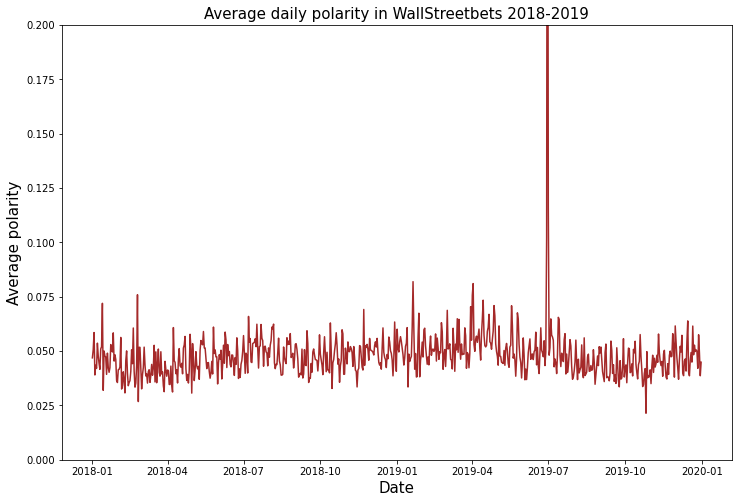

In [42]:
fig, axs = plt.subplots(1,1, figsize=(12,8))

axs.plot( daily_polarity_posts['mean_polarity'], label = "polarity", color = 'brown')
axs.set( ylim=[0,0.2],
       xlabel='Date', 
       ylabel='Average polarity',
       title='Average daily polarity in WallStreetbets 2018-2019')
axs.xaxis.label.set_size(15)
axs.yaxis.label.set_size(15)
axs.yaxis.label.set_size(15)
axs.title.set_size(15)

In [ ]:
#how many negative, neutral and positive comments in a regualr day?


In [43]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/javier/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [44]:
sid = SentimentIntensityAnalyzer()

In [51]:
sid.polarity_scores('i disagree')

{'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -0.3818}

In [52]:
df_2018_2019['vader_score'] = df_2018_2019['body_no_urls'].apply(lambda body_no_urls: sid.polarity_scores(body_no_urls))

df_2018_2019.head()

/var/folders/6g/gdb0jbcd2z1gp1wl7s548g7c0000gn/T/ipykernel_17852/3463564599.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2018_2019['vader_score'] = df_2018_2019['body_no_urls'].apply(lambda body_no_urls: sid.polarity_scores(body_no_urls))


,author,created_utc,body,score,body_no_urls,words_in_body,polarity,vader_score
1,08371A,2018-01-01 00:00:54,Bless you,6.0,Bless you,bless you,0.00,"{'neg': 0.0, 'neu': 0.263, 'pos': 0.737, 'comp..."
2,Dick_Cuckingham,2018-01-01 00:02:28,Long winded clickbait ad.,26.0,Long winded clickbait ad,long winded clickbait ad,-0.05,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
3,Shauncore,2018-01-01 00:02:42,And that's part of the point. SPY isn't just a...,11.0,And that s part of the point SPY isn t just a ...,and that s part of the point spy isn t just a ...,0.20,"{'neg': 0.049, 'neu': 0.951, 'pos': 0.0, 'comp..."
4,Shauncore,2018-01-01 00:03:25,"Undergrad, grad school, the CFA exam, and Google.",6.0,Undergrad grad school the CFA exam and Google,undergrad grad school the cfa exam and google,0.00,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
6,watchthegaps,2018-01-01 00:04:20,AAPL\nMTCH\nAMD\nDIS,1.0,AAPL MTCH AMD DIS,aapl mtch amd dis,0.00,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."


In [55]:
#Now will call out compound as a separate column and 
#all values greater than zeroes will be considered a positive comment
#and all values less than zero would be considered as a negative comment


df_2018_2019['vader_compound']  = df_2018_2019['vader_score'].apply(lambda score_dict: score_dict['compound'])

df_2018_2019.head()

/var/folders/6g/gdb0jbcd2z1gp1wl7s548g7c0000gn/T/ipykernel_17852/916097125.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2018_2019['vader_compound']  = df_2018_2019['vader_score'].apply(lambda score_dict: score_dict['compound'])


,author,created_utc,body,score,body_no_urls,words_in_body,polarity,vader_score,vader_compound
1,08371A,2018-01-01 00:00:54,Bless you,6.0,Bless you,bless you,0.00,"{'neg': 0.0, 'neu': 0.263, 'pos': 0.737, 'comp...",0.4215
2,Dick_Cuckingham,2018-01-01 00:02:28,Long winded clickbait ad.,26.0,Long winded clickbait ad,long winded clickbait ad,-0.05,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
3,Shauncore,2018-01-01 00:02:42,And that's part of the point. SPY isn't just a...,11.0,And that s part of the point SPY isn t just a ...,and that s part of the point spy isn t just a ...,0.20,"{'neg': 0.049, 'neu': 0.951, 'pos': 0.0, 'comp...",-0.1531
4,Shauncore,2018-01-01 00:03:25,"Undergrad, grad school, the CFA exam, and Google.",6.0,Undergrad grad school the CFA exam and Google,undergrad grad school the cfa exam and google,0.00,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
6,watchthegaps,2018-01-01 00:04:20,AAPL\nMTCH\nAMD\nDIS,1.0,AAPL MTCH AMD DIS,aapl mtch amd dis,0.00,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000


In [56]:
df_2018_2019.head(50)

,author,created_utc,body,score,body_no_urls,words_in_body,polarity,vader_score,vader_compound
1,08371A,2018-01-01 00:00:54,Bless you,6.0,Bless you,bless you,0.000000,"{'neg': 0.0, 'neu': 0.263, 'pos': 0.737, 'comp...",0.4215
2,Dick_Cuckingham,2018-01-01 00:02:28,Long winded clickbait ad.,26.0,Long winded clickbait ad,long winded clickbait ad,-0.050000,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
3,Shauncore,2018-01-01 00:02:42,And that's part of the point. SPY isn't just a...,11.0,And that s part of the point SPY isn t just a ...,and that s part of the point spy isn t just a ...,0.200000,"{'neg': 0.049, 'neu': 0.951, 'pos': 0.0, 'comp...",-0.1531
4,Shauncore,2018-01-01 00:03:25,"Undergrad, grad school, the CFA exam, and Google.",6.0,Undergrad grad school the CFA exam and Google,undergrad grad school the cfa exam and google,0.000000,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
6,watchthegaps,2018-01-01 00:04:20,AAPL\nMTCH\nAMD\nDIS,1.0,AAPL MTCH AMD DIS,aapl mtch amd dis,0.000000,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
7,Dick_Cuckingham,2018-01-01 00:04:36,That write up got bullish at the end. Said don...,8.0,That write up got bullish at the end Said don ...,that write up got bullish at the end said don ...,0.233333,"{'neg': 0.065, 'neu': 0.871, 'pos': 0.065, 'co...",0.0000
8,zoltanyoursavior,2018-01-01 00:05:21,I got it from the pirate bay in a torrent. It'...,1.0,I got it from the pirate bay in a torrent It s...,i got it from the pirate bay in a torrent it s...,0.000000,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
9,Dick_Cuckingham,2018-01-01 00:05:46,"When MU does what that said it would do, they ...",1.0,When MU does what that said it would do they c...,when mu does what that said it would do they c...,0.000000,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
10,dvprz,2018-01-01 00:05:51,Thanks for buying them. I'll sell you some mor...,4.0,Thanks for buying them I ll sell you some more...,thanks for buying them i ll sell you some more...,0.166667,"{'neg': 0.0, 'neu': 0.791, 'pos': 0.209, 'comp...",0.4404
11,Dick_Cuckingham,2018-01-01 00:07:01,Less than a mile away.\n\nIs this the hot sing...,82.0,Less than a mile away Is this the hot singles ...,less than a mile away is this the hot singles ...,0.041667,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000


In [57]:
#conver to positive or negative

df_2018_2019['vader_category'] = df_2018_2019['vader_compound'].apply(lambda c: 'pos' if c >=0 else 'neg')

df_2018_2019.head()

/var/folders/6g/gdb0jbcd2z1gp1wl7s548g7c0000gn/T/ipykernel_17852/4253423961.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2018_2019['vader_category'] = df_2018_2019['vader_compound'].apply(lambda c: 'pos' if c >=0 else 'neg')


,author,created_utc,body,score,body_no_urls,words_in_body,polarity,vader_score,vader_compound,vader_category
1,08371A,2018-01-01 00:00:54,Bless you,6.0,Bless you,bless you,0.00,"{'neg': 0.0, 'neu': 0.263, 'pos': 0.737, 'comp...",0.4215,pos
2,Dick_Cuckingham,2018-01-01 00:02:28,Long winded clickbait ad.,26.0,Long winded clickbait ad,long winded clickbait ad,-0.05,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,pos
3,Shauncore,2018-01-01 00:02:42,And that's part of the point. SPY isn't just a...,11.0,And that s part of the point SPY isn t just a ...,and that s part of the point spy isn t just a ...,0.20,"{'neg': 0.049, 'neu': 0.951, 'pos': 0.0, 'comp...",-0.1531,neg
4,Shauncore,2018-01-01 00:03:25,"Undergrad, grad school, the CFA exam, and Google.",6.0,Undergrad grad school the CFA exam and Google,undergrad grad school the cfa exam and google,0.00,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,pos
6,watchthegaps,2018-01-01 00:04:20,AAPL\nMTCH\nAMD\nDIS,1.0,AAPL MTCH AMD DIS,aapl mtch amd dis,0.00,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,pos


In [58]:
# following Ranco proposed formula for sentiment polarity Pd
#Get the average of polarity daily  of posts

daily_vader_polarity_posts = df_2018_2019.groupby(pd.Grouper(key='created_utc',freq='D'))['vader_category'].value_counts().unstack(fill_value=0)

daily_vader_polarity_posts


vader_category,neg,pos
created_utc,,
2018-01-01,242,728
2018-01-02,414,1252
2018-01-03,595,1610
2018-01-04,708,1680
2018-01-05,579,1455
...,...,...
2019-12-27,2191,6180
2019-12-28,1084,3225
2019-12-29,545,1475


In [59]:
daily_vader_polarity_posts['sentiment_vader'] = (daily_vader_polarity_posts['pos']-daily_vader_polarity_posts['neg'])/(daily_vader_polarity_posts['pos']+daily_vader_polarity_posts['neg'])

In [60]:
daily_vader_polarity_posts

vader_category,neg,pos,sentiment_vader
created_utc,,,
2018-01-01,242,728,0.501031
2018-01-02,414,1252,0.503001
2018-01-03,595,1610,0.460317
2018-01-04,708,1680,0.407035
2018-01-05,579,1455,0.430678
...,...,...,...
2019-12-27,2191,6180,0.476526
2019-12-28,1084,3225,0.496867
2019-12-29,545,1475,0.460396


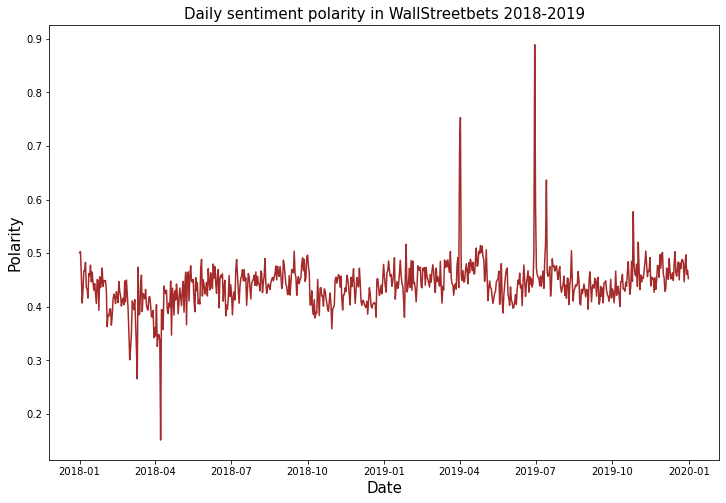

In [61]:
fig, axs = plt.subplots(1,1, figsize=(12,8))

axs.plot( daily_vader_polarity_posts['sentiment_vader'], label = "polarity", color = 'brown')
axs.set( 
       xlabel='Date', 
       ylabel='Polarity',
       title='Daily sentiment polarity in WallStreetbets 2018-2019')
axs.xaxis.label.set_size(15)
axs.yaxis.label.set_size(15)
axs.yaxis.label.set_size(15)
axs.title.set_size(15)

In [62]:
# get the SP500 tickers
table=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')


In [64]:
table[0]

,Symbol,Security,SEC filings,GICS Sector,GICS Sub-Industry,Headquarters Location,Date first added,CIK,Founded
0,MMM,3M,reports,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1976-08-09,66740,1902
1,AOS,A. O. Smith,reports,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888
3,ABBV,AbbVie,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ABMD,Abiomed,reports,Health Care,Health Care Equipment,"Danvers, Massachusetts",2018-05-31,815094,1981
...,...,...,...,...,...,...,...,...,...
498,YUM,Yum! Brands,reports,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061,1997
499,ZBRA,Zebra Technologies,reports,Information Technology,Electronic Equipment & Instruments,"Lincolnshire, Illinois",2019-12-23,877212,1969
500,ZBH,Zimmer Biomet,reports,Health Care,Health Care Equipment,"Warsaw, Indiana",2001-08-07,1136869,1927
501,ZION,Zions Bancorporation,reports,Financials,Regional Banks,"Salt Lake City, Utah",2001-06-22,109380,1873


In [78]:
df3 = df_2018_2019[df_2018_2019['body'].str.contains('YUM', na=False)]

In [79]:
from pandas import option_context

with option_context('display.max_colwidth', 400):
    display(df3)

,author,created_utc,body,score,body_no_urls,words_in_body,polarity,vader_score,vader_compound,vader_category
4948,anooblol,2018-01-03 20:59:49,Fun fact. When I was in 5th grade we had a stock trading assignment. I convinced my classmates to buy YUM because I loved taco bell. I would have went long at $14.50\n\n5th grade me would have made 460%,39.0,Fun fact When I was in 5th grade we had a stock trading assignment I convinced my classmates to buy YUM because I loved taco bell I would have went long at 14 50 5th grade me would have made 460,fun fact when i was in 5th grade we had a stock trading assignment i convinced my classmates to buy yum because i loved taco bell i would have went long at 14 50 5th grade me would have made 460,0.316667,"{'neg': 0.0, 'neu': 0.769, 'pos': 0.231, 'compound': 0.872}",0.8720,pos
5653,KingOfTheCouch13,2018-01-04 01:21:03,Taco Bell got them Mexican fries rolling out. That's all the DD I need to invest in YUM,4.0,Taco Bell got them Mexican fries rolling out That s all the DD I need to invest in YUM,taco bell got them mexican fries rolling out that s all the dd i need to invest in yum,0.000000,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",0.0000,pos
6174,Bottys,2018-01-04 08:08:34,how bout that YUMC tho\n\nkfc and china christmas,1.0,how bout that YUMC tho kfc and china christmas,how bout that yumc tho kfc and china christmas,0.000000,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",0.0000,pos
6191,questionable_plays,2018-01-04 08:23:53,I thought $YUM had something to do with Cafe Yumm. Would have been the easiest buy of the century. Cafe Yumm is where white people pay 10 dollars for a small bowl of rice. Literally peasant food for 10 dollars.,1.0,I thought YUM had something to do with Cafe Yumm Would have been the easiest buy of the century Cafe Yumm is where white people pay 10 dollars for a small bowl of rice Literally peasant food for 10 dollars,i thought yum had something to do with cafe yumm would have been the easiest buy of the century cafe yumm is where white people pay 10 dollars for a small bowl of rice literally peasant food for 10 dollars,-0.125000,"{'neg': 0.035, 'neu': 0.896, 'pos': 0.07, 'compound': 0.34}",0.3400,pos
6348,FistyGorilla,2018-01-04 13:39:54,I've been buying YUMC.,1.0,I ve been buying YUMC,i ve been buying yumc,0.000000,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",0.0000,pos
...,...,...,...,...,...,...,...,...,...,...
5252275,DJRenzor,2019-12-23 17:32:23,MCD and YUM making me feel old watching their movement,1.0,MCD and YUM making me feel old watching their movement,mcd and yum making me feel old watching their movement,0.100000,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",0.0000,pos
5253945,DJRenzor,2019-12-23 20:31:17,MCD and YUM please do something lol,2.0,MCD and YUM please do something lol,mcd and yum please do something lol,0.800000,"{'neg': 0.0, 'neu': 0.495, 'pos': 0.505, 'compound': 0.6249}",0.6249,pos
5256990,Solus-Zuvys,2019-12-24 05:53:34,"up 5k today! Put in 3k, YUMMY!",1.0,up 5k today Put in 3k YUMMY,up 5k today put in 3k yummy,0.000000,"{'neg': 0.0, 'neu': 0.592, 'pos': 0.408, 'compound': 0.6289}",0.6289,pos
5270854,27onfire,2019-12-26 17:45:02,Which YUM location do you work at? I'll bring you over some 4-ply for big wide asses.,2.0,Which YUM location do you work at I ll bring you over some 4 ply for big wide asses,which yum location do you work at i ll bring you over some 4 ply for big wide asses,-0.050000,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",0.0000,pos
